# Face Detection on Custom Dataset with Detectron2

Face detection is the task of finding (boundaries of) faces in images. This is useful for
- security systems (the first step in recognizing a person)
- autofocus and smile detection for making great photos
- detecting age, race, and emotional state for markering (yep, we already live in that world)

Historically, this was a really tough problem to solve. Tons of manual feature engineering, novel algorithms and methods were developed to improve the state-of-the-art.

These days, face detection models are included in almost every computer vision package/framework. Some of the best-performing ones use Deep Learning methods. OpenCV, for example, provides a variety of tools like the [Cascade Classifier](https://docs.opencv.org/4.2.0/db/d28/tutorial_cascade_classifier.html).

- [Run the complete notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1Jk4-qX9zdYGsBrTnh2vF52CV9ucuqpjk)
- [Read the **Getting Things Done with Pytorch** book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

In this guide, you'll learn how to:
- prepare a custom dataset for face detection with Detectron2
- use (close to) state-of-the-art models for object detection to find faces in images
- You can extend this work for face recognition.

Here's an example of what you'll get at the end of this guide:


<img src='https://www.curiousily.com/media/pytorch-02/social-image.png' />


## Detectron 2

<img src="https://www.curiousily.com/media/pytorch-02/detectron2-logo.png" width="55%">

[Detectron2](https://github.com/facebookresearch/detectron2) is a framework for building state-of-the-art object detection and image segmentation models. It is developed by the Facebook Research team. Detectron2 is a complete rewrite of the [first version](https://github.com/facebookresearch/Detectron).

Under the hood, Detectron2 uses PyTorch (compatible with the latest version(s)) and allows for [blazing fast training](https://detectron2.readthedocs.io/notes/benchmarks.html). You can learn more at [introductory blog post](https://ai.facebook.com/blog/-detectron2-a-pytorch-based-modular-object-detection-library-/) by Facebook Research.

The real power of Detectron2 lies in the HUGE amount of pre-trained models available at the [Model Zoo](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md). But what good that would it be if you can't fine-tune those on your own datasets? Fortunately, that's super easy! We'll see how it is done in this guide.

### Installing Detectron2

At the time of this writing, Detectron2 is still in an alpha stage. While there is an official release, we'll clone and compile from the master branch. This should equal version 0.1.

Let's start by installing some requirements:

In [ ]:
!pip install -q cython pyyaml==6.0.1
!pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Preparing metadata (setup.py) ... done


And download, compile, and install the Detectron2 package:

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-kn57uboe
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-kn57uboe
  Resolved https://github.com/facebookresearch/detectron2.git to commit 92ae9f0b92aba5867824b4f12aa06a22a60a45d3
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for detectron2: filename=detectron2

> At this point, you'll need to restart the notebook runtime to continue!

In [ ]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.8 MB/s eta 0:00:00


In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,pycocotools,torch,torchvision,detectron2

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

numpy      : 1.25.2
pandas     : 2.0.3
pycocotools: 2.0.7
torch      : 2.2.1+cu121
torchvision: 0.17.1+cu121
detectron2 : 0.6



In [ ]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

import glob

import os
import ntpath
import numpy as np
import cv2
import random
import itertools
import pandas as pd
from tqdm import tqdm
import urllib
import json
import PIL.Image as Image

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.structures import BoxMode

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Face Detection Data

Our dataset is provided by [Dataturks](https://dataturks.com/), and it is hosted on [Kaggle](https://www.kaggle.com/dataturks/face-detection-in-images). Here's an excerpt from the description:

> Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

I've downloaded the JSON file containing the annotations and uploaded it to Google Drive. Let's get it:

In [ ]:
import gdown
!gdown --id 1G5bAb1iMWX3_Zb42WgIkrTBJEXofhEJl

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1G5bAb1iMWX3_Zb42WgIkrTBJEXofhEJl
To: /content/wider_face_train_annot_coco_style.json
100% 92.9M/92.9M [00:00<00:00, 140MB/s]


Let's load the file into a Pandas dataframe:

In [ ]:
with open('/content/wider_face_train_annot_coco_style.json', 'r') as file:
    data = json.load(file)

categories = data["categories"]
images = data["images"]
annotations = data["annotations"]

In [ ]:
categories_id = data["categories"][0]["name"]
print(categories_id)

face


Each line contains a single face annotation. Note that multiple lines might point to a single image (e.g. multiple faces per image).

## Data Preprocessing

The dataset contains only image URLs and annotations. We'll have to download the images. We'll also normalize the annotations, so it's easier to use them with Detectron2 later on:

In [ ]:
def process_annotation(annotation):
  # Extract bounding box data
  bbox = annotation["bbox"]

  # Bounding box coordinates
  x_min = bbox[0]
  y_min = bbox[1]
  width = bbox[2]
  height = bbox[3]

  # Bounding box area
  bbox_area = annotation["area"]

  if bbox_area == 0:
      return None

  # Calculate the maximum and minimum values for normalization
  max_value = max(x_min, y_min, x_min + width, y_min + height)
  min_value = min(x_min, y_min, x_min + width, y_min + height)
  range_value = max_value - min_value

  # Normalize the coordinates using min-max normalization
  x_min_norm = (x_min - min_value) / range_value
  y_min_norm = (y_min - min_value) / range_value
  x_max_norm = ((x_min + width) - min_value) / range_value
  y_max_norm = ((y_min + height) - min_value) / range_value

  return {
      "file_name": annotation["image_id"],
      "bbox_area": bbox_area,
      "x_min": x_min_norm,
      "y_min": y_min_norm,
      "x_max": x_max_norm,
      "y_max": y_max_norm,
      "class_name": "face",
  }

def preprocess_and_save(annotations, image_directory):
    dataset = []

    for annotation in annotations:
        processed_data = process_annotation(annotation)
        if processed_data:
            dataset.append(processed_data)

            # Save the corresponding image
            file_name = processed_data["file_name"]
            file_path = f'{image_directory}/{file_name}'
            if not os.path.exists(file_path):
                # Code to save or copy image to this path
                # Ensure `faces/` contains necessary images or adapt this part
                pass

    # Convert the dataset to a DataFrame
    df = pd.DataFrame(dataset)

    print(df.head())
    df.to_csv('annotations.csv', header=True, index=None)

In [ ]:
preprocess_and_save(annotations, "faces")

   file_name  bbox_area     x_min     y_min     x_max     y_max class_name
0          0    18178.0  0.493776  0.000000  1.000000  0.618257       face
1          1    89157.0  0.500000  0.000000  1.000000  0.644487       face
2          2       56.0  0.000000  0.947020  0.046358  1.000000       face
3          2      238.0  0.000000  0.903955  0.079096  1.000000       face
4          2      165.0  0.000000  0.868421  0.096491  1.000000       face


Let's put the data into a dataframe so we can have a better look:

In [ ]:
df = pd.DataFrame(dataset)
df.head()

,file_name,bbox_area,x_min,y_min,x_max,y_max,class_name
0,0,18178.0,0.493776,0.000000,1.000000,0.618257,face
1,1,89157.0,0.500000,0.000000,1.000000,0.644487,face
2,2,56.0,0.000000,0.947020,0.046358,1.000000,face
3,2,238.0,0.000000,0.903955,0.079096,1.000000,face
4,2,165.0,0.000000,0.868421,0.096491,1.000000,face


In [ ]:
print(df.file_name.unique().shape[0], df.shape[0])

12876 159393


We have a total of 409 images (a lot less than the promised 500) and 1132 annotations. Let's save them to the disk (so you might reuse them):

### Data Exploration

Let's see some sample annotated data. We'll use OpenCV to load an image, add the bounding boxes, and resize it. We'll define a helper function to do it all:

In [ ]:
def annotate_image(annotations, resize=True):
    if annotations.empty:
        print("No annotations found for this image.")
        return None

    file_name = annotations['file_name'].to_numpy()[0]
    file_path = f'faces/{file_name}'

    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return None

    img = cv2.cvtColor(cv2.imread(file_path), cv2.COLOR_BGR2RGB)

    for i, a in annotations.iterrows():
        cv2.rectangle(img, (a.x_min, a.y_min), (a.x_max, a.y_max), (0, 255, 0), 2)

    if not resize:
        return img

    return cv2.resize(img, (384, 384), interpolation=cv2.INTER_AREA)



Let's start by showing some annotated images:

In [ ]:
unique_files = df['file_name'].unique()

for file in unique_files[:5]:  # Display the first 5 images
    img_df = df[df['file_name'] == file]

    if img_df.empty:
        print(f"No annotations found for file: {file}")
        continue

    annotated_img = annotate_image(img_df)

    if annotated_img is not None:
        plt.figure(figsize=(8, 8))
        plt.imshow(annotated_img)
        plt.title(f"Annotations for {file}")
        plt.axis("off")
        plt.show()

File not found: faces/0
File not found: faces/1
File not found: faces/2
File not found: faces/3
File not found: faces/4


Error: Image file faces/1 does not exist.


TypeError: Image data of dtype object cannot be converted to float

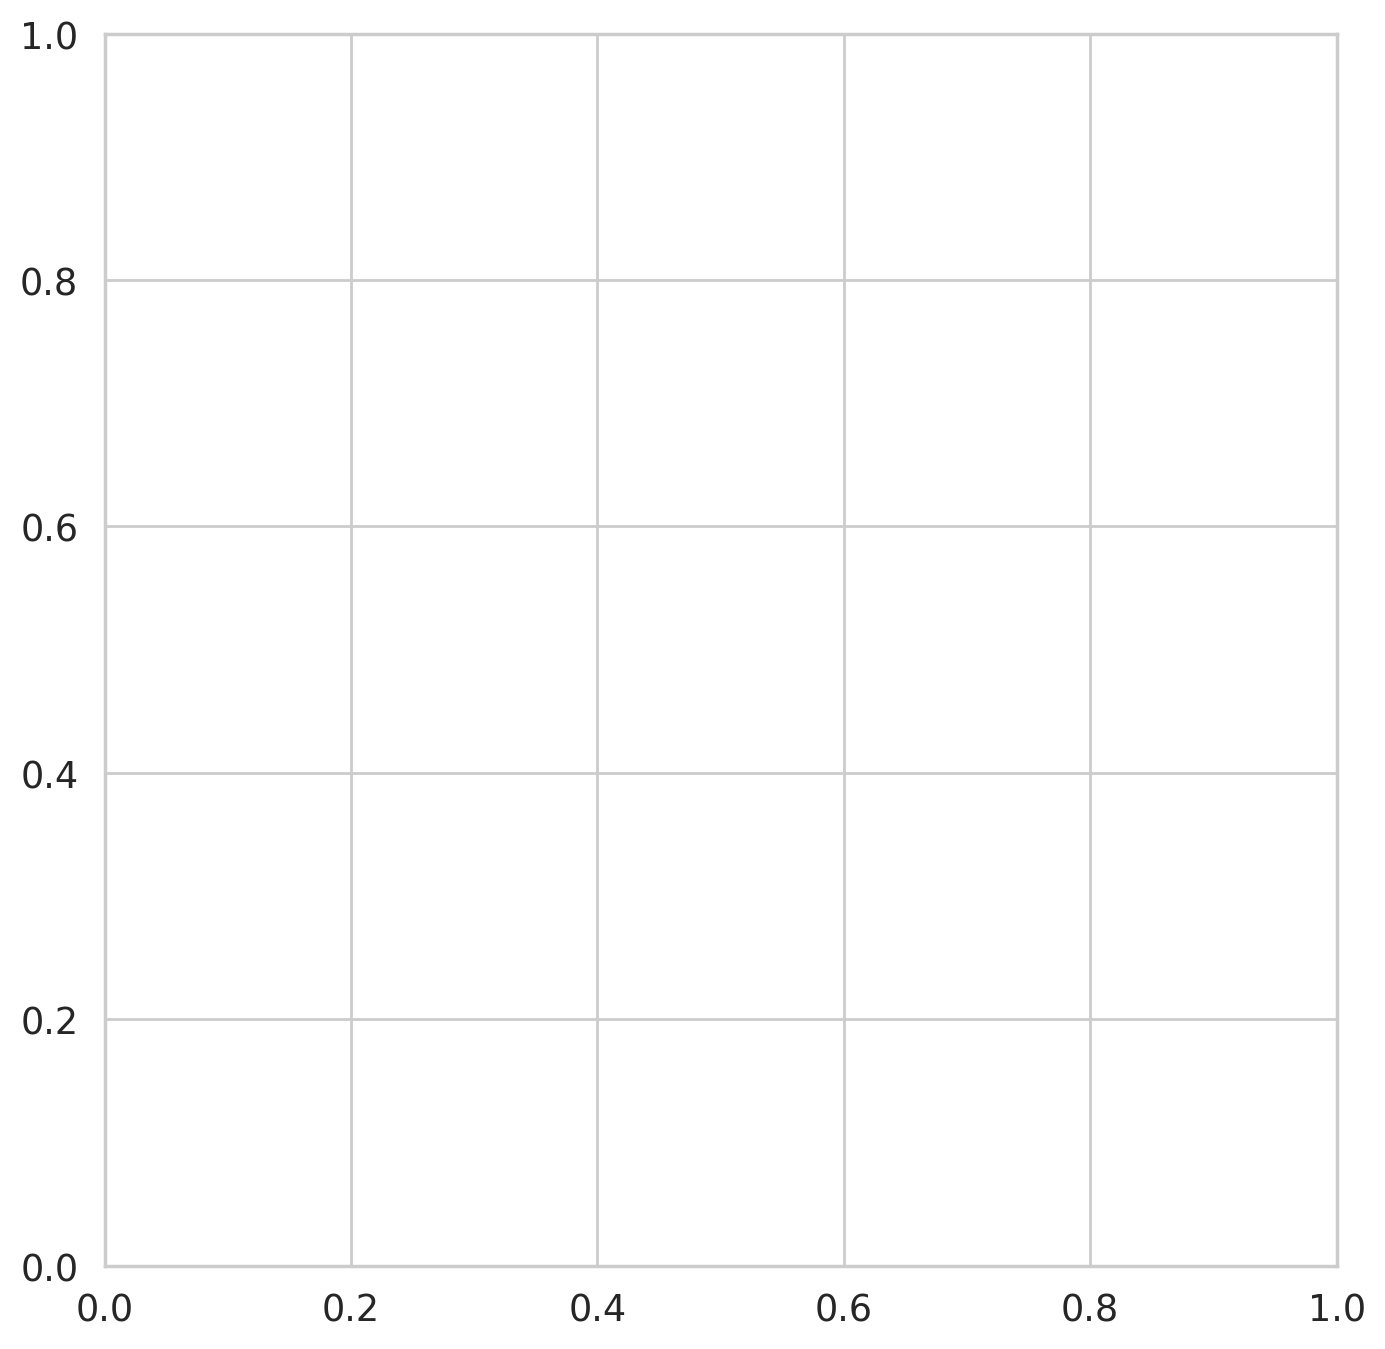

In [ ]:
img_df = df[df.file_name == df.file_name.unique()[1]]
img = annotate_image(img_df, resize=False)

plt.imshow(img)
plt.axis('off');

Those are good ones, the annotations are clearly visible. We can use torchvision to create a grid of images. Note that the images are in various sizes, so we'll resize them:

In [ ]:
sample_images = [annotate_image(df[df.file_name == f]) for f in df.file_name.unique()[:10]]
sample_images = torch.as_tensor(sample_images)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
sample_images.shape

In [ ]:
sample_images = sample_images.permute(0, 3, 1, 2)

In [ ]:
sample_images.shape

In [ ]:
plt.figure(figsize=(24, 12))
grid_img = torchvision.utils.make_grid(sample_images, nrow=5)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off');

You can clearly see that some annotations are missing (column 4). That's real life data for you, sometimes you have to deal with it in some way.

## Face Detection with Detectron 2

It is time to go through the steps of fine-tuning a model using a custom dataset. But first, let's save 5% of the data for testing:

In [ ]:
df = pd.read_csv('annotations.csv')

IMAGES_PATH = f'faces'

unique_files = df.file_name.unique()

train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.95), replace=False))
train_df = df[df.file_name.isin(train_files)]
test_df = df[~df.file_name.isin(train_files)]

train_df.head()

,file_name,bbox_area,x_min,y_min,x_max,y_max,class_name
0,0,18178.0,0.493776,0.000000,1.000000,0.618257,face
1,1,89157.0,0.500000,0.000000,1.000000,0.644487,face
2,2,56.0,0.000000,0.947020,0.046358,1.000000,face
3,2,238.0,0.000000,0.903955,0.079096,1.000000,face
4,2,165.0,0.000000,0.868421,0.096491,1.000000,face


The classical train_test_split won't work here, cause we want a split amongst the file names.

The next parts are written in a bit more generic way. Obviously, we have a single class - face. But adding more should be as simple as adding more annotations to the dataframe:

In [ ]:
classes = df.class_name.unique().tolist()

Next, we'll write a function that converts our dataset into a format that is used by Detectron2:

In [ ]:
def create_dataset_dicts(df, classes):
  dataset_dicts = []
  for image_id, img_name in enumerate(df.file_name.unique()):

    record = {}

    image_df = df[df.file_name == img_name]

    file_path = f'{IMAGES_PATH}/{img_name}'
    record["file_name"] = file_path
    record["image_id"] = image_id
    record["height"] = int(image_df.iloc[0].height)
    record["width"] = int(image_df.iloc[0].width)

    objs = []
    for _, row in image_df.iterrows():

      xmin = int(row.x_min)
      ymin = int(row.y_min)
      xmax = int(row.x_max)
      ymax = int(row.y_max)

      poly = [
          (xmin, ymin), (xmax, ymin),
          (xmax, ymax), (xmin, ymax)
      ]
      poly = list(itertools.chain.from_iterable(poly))

      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": classes.index(row.class_name),
        "iscrowd": 0
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

We convert every annotation row to a single record with a list of annotations. You might also notice that we're building a polygon that is of the exact same shape as the bounding box. This is required for the image segmentation models in Detectron2.

You'll have to register your dataset into the dataset and metadata catalogues:

In [ ]:
for d in ["train", "val"]:
  DatasetCatalog.register("faces_" + d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
  MetadataCatalog.get("faces_" + d).set(thing_classes=classes)

statement_metadata = MetadataCatalog.get("faces_train")

Unfortunately, evaluator for the test set is not included by default. We can easily fix that by writing our own trainer:

In [ ]:
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

The evaluation results will be stored in the `coco_eval` folder if no folder is provided.

Fine-tuning a Detectron2 model is nothing like writing PyTorch code. We'll load a configuration file, change a few values, and start the training process. But hey, it really helps if you know what you're doing 😂

For this tutorial, we'll use the Mask R-CNN X101-FPN model. It is pre-trained on the [COCO dataset](http://cocodataset.org/#home) and achieves very good performance. The downside is that it is slow to train.

Let's load the config file and the pre-trained model weights:

In [ ]:
cfg = get_cfg()

cfg.merge_from_file(
  model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
  )
)

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
  "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
)

Specify the datasets (we registered those) we'll use for training and evaluation:

In [ ]:
cfg.DATASETS.TRAIN = ("faces_train",)
cfg.DATASETS.TEST = ("faces_val",)
cfg.DATALOADER.NUM_WORKERS = 4

And for the optimizer, we'll do a bit of magic to converge to something nice:

In [ ]:
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

Except for the standard stuff (batch size, max number of iterations, and learning rate) we have a couple of interesting params:

- `WARMUP_ITERS` - the learning rate starts from 0 and goes to the preset one for this number of iterations
- `STEPS` - the checkpoints (number of iterations) at which the learning rate will be reduced by `GAMMA`

Finally, we'll specify the number of classes and the period at which we'll evaluate on the test set:

In [ ]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)

cfg.TEST.EVAL_PERIOD = 500

Time to train, using our custom trainer:

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## Evaluating Object Detection Models

Evaluating object detection models is a bit different when compared to evaluating standard classification or regression models.

The main metric you need to know about is IoU (intersection over union). It measures the overlap between two boundaries - the predicted and ground truth one. It can get values between 0 and 1.

$$\text{IoU}=\frac{\text{area of overlap}}{\text{area of union}}$$

Using IoU, one can define a threshold (e.g. >0.5) to classify whether a prediction is a true positive (TP) or a false positive (FP).

Now you can calculate average precision (AP) by taking the area under the precision-recall curve.

Now AP@X (e.g. AP50) is just AP at some IoU threshold. This should give you a working understanding of how object detection models are evaluated.

I suggest you read the [mAP (mean Average Precision) for Object Detection](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173) tutorial by Jonathan Hui if you want to learn more on the topic.

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir output

I've prepared a pre-trained model for you, so you don't have to wait for the training to complete. Let's download it:

In [ ]:
!gdown --id 18Ev2bpdKsBaDufhVKf0cT6RmM3FjW3nL
!mv face_detector.pth output/model_final.pth

We can start making predictions by loading the model and setting a minimum threshold of 85% certainty at which we'll consider the predictions as correct:

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)

Let's run the evaluator with the trained model:

In [ ]:
evaluator = COCOEvaluator("faces_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "faces_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

### Finding Faces in Images

Next, let's create a folder and save all images with predicted annotations in the test set:

In [ ]:
os.makedirs("annotated_results", exist_ok=True)

test_image_paths = test_df.file_name.unique()

In [ ]:
for clothing_image in test_image_paths:
  file_path = f'{IMAGES_PATH}/{clothing_image}'
  im = cv2.imread(file_path)
  outputs = predictor(im)
  v = Visualizer(
    im[:, :, ::-1],
    metadata=statement_metadata,
    scale=1.,
    instance_mode=ColorMode.IMAGE
  )
  instances = outputs["instances"].to("cpu")
  instances.remove('pred_masks')
  v = v.draw_instance_predictions(instances)
  result = v.get_image()[:, :, ::-1]
  file_name = ntpath.basename(clothing_image)
  write_res = cv2.imwrite(f'annotated_results/{file_name}', result)

Let's have a look:

In [ ]:
annotated_images = [f'annotated_results/{f}' for f in test_df.file_name.unique()]

In [ ]:
img = cv2.cvtColor(cv2.imread(annotated_images[0]), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

In [ ]:
img = cv2.cvtColor(cv2.imread(annotated_images[1]), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

In [ ]:
img = cv2.cvtColor(cv2.imread(annotated_images[3]), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

In [ ]:
img = cv2.cvtColor(cv2.imread(annotated_images[4]), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

Not bad. Not bad at all. I suggest you explore more images on your own, too!

Note that some faces have multiple bounding boxes (on the second image) with different degrees of certainty. Maybe training the model longer will help? How about adding more or augmenting the existing data?

## Conclusion

Congratulations! You now know the basics of Detectron2 for object detection! You might be surprised by the results, given the small dataset we have. That's the power of large pre-trained models for you 😍

- [Run the complete notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1Jk4-qX9zdYGsBrTnh2vF52CV9ucuqpjk)
- [Read the **Getting Things Done with Pytorch** book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:
- prepare a custom dataset for face detection with Detectron2
- use (close to) state-of-the-art models for object detection to find faces in images
- You can extend this work for face recognition.

## References

- [Face Detection in Images](https://www.kaggle.com/dataturks/face-detection-in-images)
- [Detectron2 on GitHub](https://github.com/facebookresearch/detectron2/)
- [mAP (mean Average Precision) for Object Detection](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173)